In [36]:
import os
import glob
import numpy as np
import xarray as xr
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

from PIL import Image
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

In [5]:
data_dir = 'xxx/SFE-raw-data'
out_dir = './tmp'

os.makedirs(out_dir, exist_ok=True)

## E008

In [6]:
temp = xr.open_mfdataset(sorted(glob.glob(f'{data_dir}/GODAS/*.nc')))
temp = temp.sel(time=slice('1991-01', '2020-12'))
temp_clim = temp.groupby('time.month').mean(dim='time')

In [8]:
region_map = {
    # Tropical Pacific
    'Eastern Equatorial Pacific': [240, 280, -10, 0],
    'Western Pacific Warm Pool': [140, 190, 0, 10],
    # Tropical Indian Ocean
    'Bay of Bengal': [80, 95, 5, 22],
    # Eastern Boundary Upwelling Zone
    'Peru-Chile Coast': [280, 290, -30, -5],
    'California Coast': [235, 245, 25, 40],
    # Western boundary strong current area
    'Kuroshio': [130, 150, 25, 35],
    'Gulfstream': [285, 295, 30, 40],
    # High latitude sea areas
    'Labrador Sea': [300, 315, 50, 65],
    # Coral reef distribution area
    'Red Sea': [32, 43, 12, 28],
    # Coastal and marginal seas
    'Mediterranean': [0, 36, 30, 45]
}
regions = list(region_map.keys())

In [18]:
cm = 1/2.54

tick_size=7
label_size=8

month = 7

os.makedirs(f'{out_dir}/thermocline', exist_ok=True)

for region in regions:
    plt.figure(figsize=(6*cm, 8*cm), dpi=300)

    max_depth = 400
    lon_min, lon_max, lat_min, lat_max = region_map[region]
    values = temp_clim.sel(month=month, level=slice(0, max_depth), lon=slice(lon_min, lon_max), lat=slice(lat_min, lat_max)).mean(dim=['lon', 'lat'])
    values = values - 273.15
    plt.plot(values.pottmp.values, values.level.values, linewidth=1.5, marker='s', ms=2)

    plt.gca().set_facecolor('#f7f7f7')

    plt.xlabel('Temperature [°C]', fontsize=label_size)
    plt.ylabel('Depth [m]', fontsize=label_size)

    plt.xticks(fontsize=tick_size)

    plt.yticks(np.arange(0, max_depth+1, 50), fontsize=tick_size, minor=True)
    plt.yticks(np.arange(0, max_depth+1, 100), fontsize=tick_size, minor=False)

    plt.grid(which='major', axis='y', linestyle='--', alpha=0.7,)
    plt.grid(which='minor', axis='y', linestyle=':', alpha=0.7,)

    plt.gca().invert_yaxis()
    plt.savefig(f"{out_dir}/thermocline/{region.replace(' ', '_')}.png", bbox_inches='tight')

    plt.close()
    plt.clf()

<Figure size 640x480 with 0 Axes>

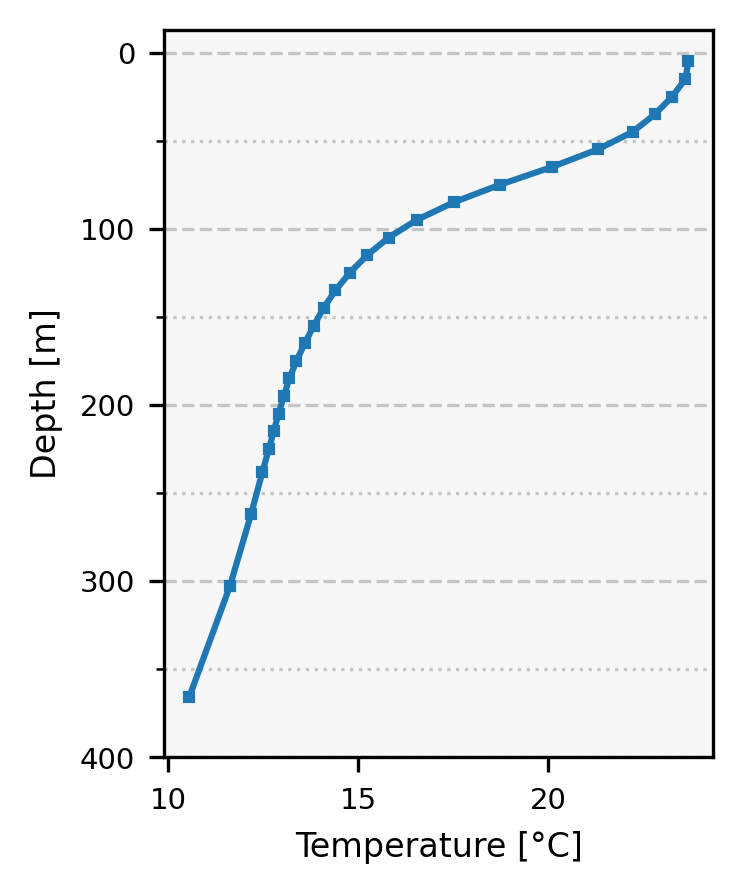

In [19]:
Image.open(f"{out_dir}/thermocline/{regions[0].replace(' ', '_')}.png")

## E014

In [11]:
t2m = xr.open_dataset(f'{data_dir}/ERA5/t2m.nc')
t2m_1981_2020 = t2m.sel(valid_time=slice('1981-01', '2020-12'))
t2m_1981_2020_global_mean = t2m_1981_2020.mean(dim=['latitude', 'longitude'])
t2m_1981_2020_global_year_mean = t2m_1981_2020_global_mean.groupby('valid_time.year').mean()

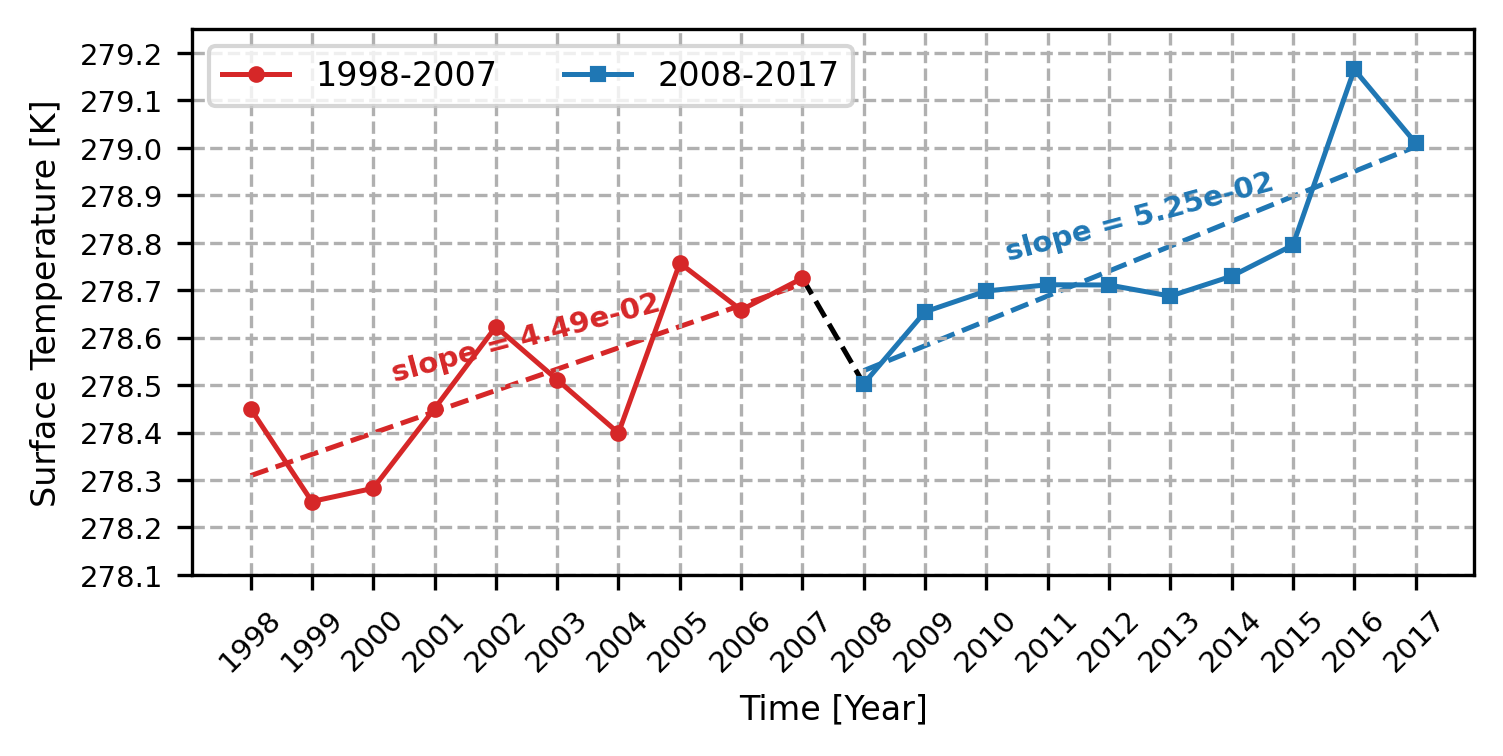

In [12]:
cm = 1/2.54
plt.figure(figsize=(14*cm, 6*cm), dpi=300)
tick_size = 7
label_size = 8

values = t2m_1981_2020_global_year_mean.t2m.values
x = np.arange(20)

st_year = 1998
ed_year = 2017

offset1 = st_year - 1981
offset2 = offset1 + 10

plt.plot(x[9:11], values[offset1+9:offset1+11], color='black', linewidth=1.2, linestyle='--')
red_line = plt.plot(x[:10], values[offset1:offset1+10], color='tab:red', linewidth=1.2, 
                   label=f'{st_year}-{st_year+9}', marker='o', ms=3)
blue_line = plt.plot(x[10:], values[offset2:offset2+10], color='tab:blue', linewidth=1.2,
                    label=f'{st_year+10}-{ed_year}', marker='s', ms=3)

def add_slope_label(x_data, y_data, color):
    coeff = np.polyfit(x_data, y_data, 1)
    fit_y = np.polyval(coeff, x_data)
    
    mid_x = np.mean(x_data)
    mid_y = np.polyval(coeff, mid_x)
    
    y_offset = 0.015 if coeff[0] > 0 else -0.015
    va = 'bottom' if coeff[0] > 0 else 'top'
    
    slope_sci = "{:.2e}".format(coeff[0])
    plt.text(mid_x, mid_y - y_offset, f'slope = {slope_sci}',
             color=color, fontsize=tick_size, 
             ha='center', va=va, rotation=15, fontweight='bold')  # 小角度旋转更美观
    return fit_y

fit_red = add_slope_label(x[:10], values[offset1:offset1+10], 'tab:red')
plt.plot(x[:10], fit_red, color='tab:red', linestyle='--', linewidth=1.2, zorder=1)

fit_blue = add_slope_label(x[10:], values[offset2:offset2+10], 'tab:blue')
plt.plot(x[10:], fit_blue, color='tab:blue', linestyle='--', linewidth=1.2, zorder=1)


plt.ylim(278.15, 279.25) # Need to adjust according to the year
plt.yticks(np.linspace(278.1, 279.2, 12), fontsize=tick_size) # Need to adjust according to the year
plt.xticks(x, np.arange(st_year, ed_year+1), fontsize=tick_size, rotation=45)
plt.grid(which='major', axis='both', linestyle='--')

plt.xlabel('Time [Year]', fontsize=label_size)
plt.ylabel('Surface Temperature [K]', fontsize=label_size)

plt.legend(fontsize=8, ncol=2)

os.makedirs(f'{out_dir}/era5_t2m_series', exist_ok=True)

plt.savefig(f'{out_dir}/era5_t2m_series/{st_year}-{ed_year}.png', bbox_inches='tight')

## E016

In [31]:
godas_temp = xr.open_mfdataset(sorted(glob.glob(f'{data_dir}/GODAS/*.nc'))) - 273.15
godas_temp = godas_temp.sel(time=slice('1981-01', '2010-12'))
godas_temp_clim = godas_temp.groupby('time.month').mean(dim='time')

bcc_temp = xr.open_mfdataset(sorted(glob.glob(f'{data_dir}/CMIP6/thetao*BCC-CSM2-MR*.nc')))
bcc_temp_clim = bcc_temp.sel(time=slice('1981-01', '2010-12')).groupby('time.month').mean(dim='time')

cas_temp = xr.open_mfdataset(sorted(glob.glob(f'{data_dir}/CMIP6/thetao*CAS-ESM2-0*.nc')))
cas_temp_clim = cas_temp.sel(time=slice('1981-01', '2010-12')).groupby('time.month').mean(dim='time')

inm_temp = xr.open_mfdataset(sorted(glob.glob(f'{data_dir}/CMIP6/thetao*INM-CM5-0*.nc')))
inm_temp_clim = inm_temp.sel(time=slice('1981-01', '2010-12')).groupby('time.month').mean(dim='time')

In [24]:
region_map = {
    # Tropical Pacific
    'Eastern Equatorial Pacific': [240, 280, -10, 0],
    'Western Pacific Warm Pool': [140, 190, 0, 10],
    # Tropical Indian Ocean
    'Arabian Sea': [50, 70, 10, 25],
    'Bay of Bengal': [80, 95, 5, 22],
    # Eastern Boundary Upwelling Zone
    'Peru-Chile Coast': [280, 290, -30, -5],
    'California Coast': [235, 245, 25, 40],
    'Benguela Current': [5, 15, -35, -15],
    # Western boundary strong current area
    'Kuroshio': [130, 150, 25, 35],
    'Gulfstream': [285, 295, 30, 40],
    'East Australian Current': [150, 160, -40, -25],
    # Subtropical Convergence Zone
    'Sargasso Sea': [310, 330, 20, 35],
    'South Pacific Subtropical': [240, 280, -40, -25],
    # High latitude sea areas
    'Labrador Sea': [300, 315, 50, 65],
    # Coral reef distribution area
    'Great Barrier Reef': [145, 155, -25, -10],
    'Caribbean Sea': [275, 300, 10, 25],
    'Red Sea': [32, 43, 12, 28],
    # Coastal and marginal seas
    'East China Sea': [120, 130, 25, 35],
    'South China Sea': [105, 120, 5, 25],
    'Gulf of Mexico': [260, 280, 18, 30],
    'Mediterranean': [0, 36, 30, 45]
}
regions = list(region_map.keys())

In [32]:
month = 12
max_depth = 400

def plot(region, cmip_clim, cmip_name):
    
    lon_min, lon_max, lat_min, lat_max = region_map[region]
    y1 = godas_temp_clim.sel(month=month, level=slice(0, max_depth), lon=slice(lon_min, lon_max), lat=slice(lat_min, lat_max)).mean(dim=['lon', 'lat'])
    y2 = cmip_clim.sel(month=month, lev=slice(0, max_depth), lon=slice(lon_min, lon_max), lat=slice(lat_min, lat_max)).mean(dim=['lon', 'lat'])

    cm = 1/2.54
    plt.figure(figsize=(6*cm, 8*cm), dpi=300)

    tick_size=7
    label_size=8

    plt.plot(y1.pottmp.values, y1.level.values, color='black', linewidth=1.5, marker='o', ms=2.5, label='GODAS')
    plt.plot(y2.thetao.values, y2.lev.values, color='tab:red', linewidth=1.5, marker='s', ms=2.5, label=cmip_name)

    plt.gca().set_facecolor('#f7f7f7')

    plt.xlabel('Temperature [°C]', fontsize=label_size)
    plt.ylabel('Depth [m]', fontsize=label_size)

    plt.yticks(np.arange(0, max_depth+1, 50), fontsize=tick_size, minor=True)
    plt.yticks(np.arange(0, max_depth+1, 100), fontsize=tick_size, minor=False)

    plt.grid(which='major', axis='y', linestyle='--', alpha=0.7,)
    plt.grid(which='minor', axis='y', linestyle=':', alpha=0.7,)

    plt.gca().invert_yaxis()

    plt.legend(fontsize=8)

    os.makedirs(f"{out_dir}/cmip6_cmp", exist_ok=True)
    plt.savefig(f"{out_dir}/cmip6_cmp/{region.replace(' ', '_')}_{cmip_name}.png", bbox_inches='tight')

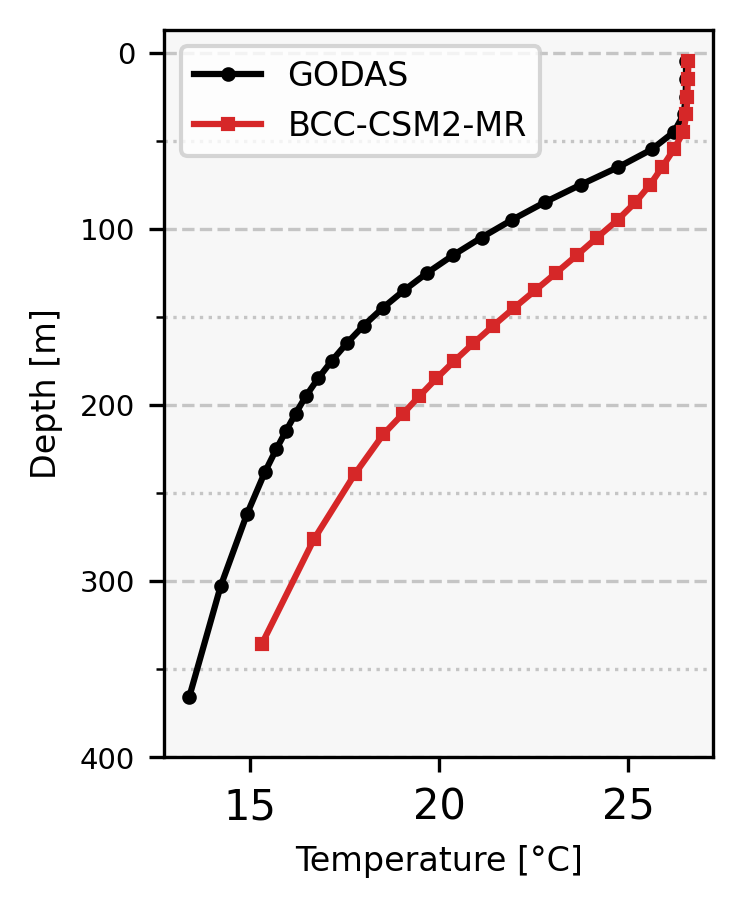

In [33]:
plot('Arabian Sea', bcc_temp_clim, 'BCC-CSM2-MR')

## E017

In [34]:
t2m = xr.open_dataset(f'{data_dir}/ERA5/t2m.nc')
t2m_1991_2020 = t2m.sel(valid_time=slice('1991-01', '2020-12'))
t2m_clim = t2m_1991_2020.groupby('valid_time.month').mean(dim='valid_time')
t2m_ano = t2m_1991_2020.groupby('valid_time.month') - t2m_clim

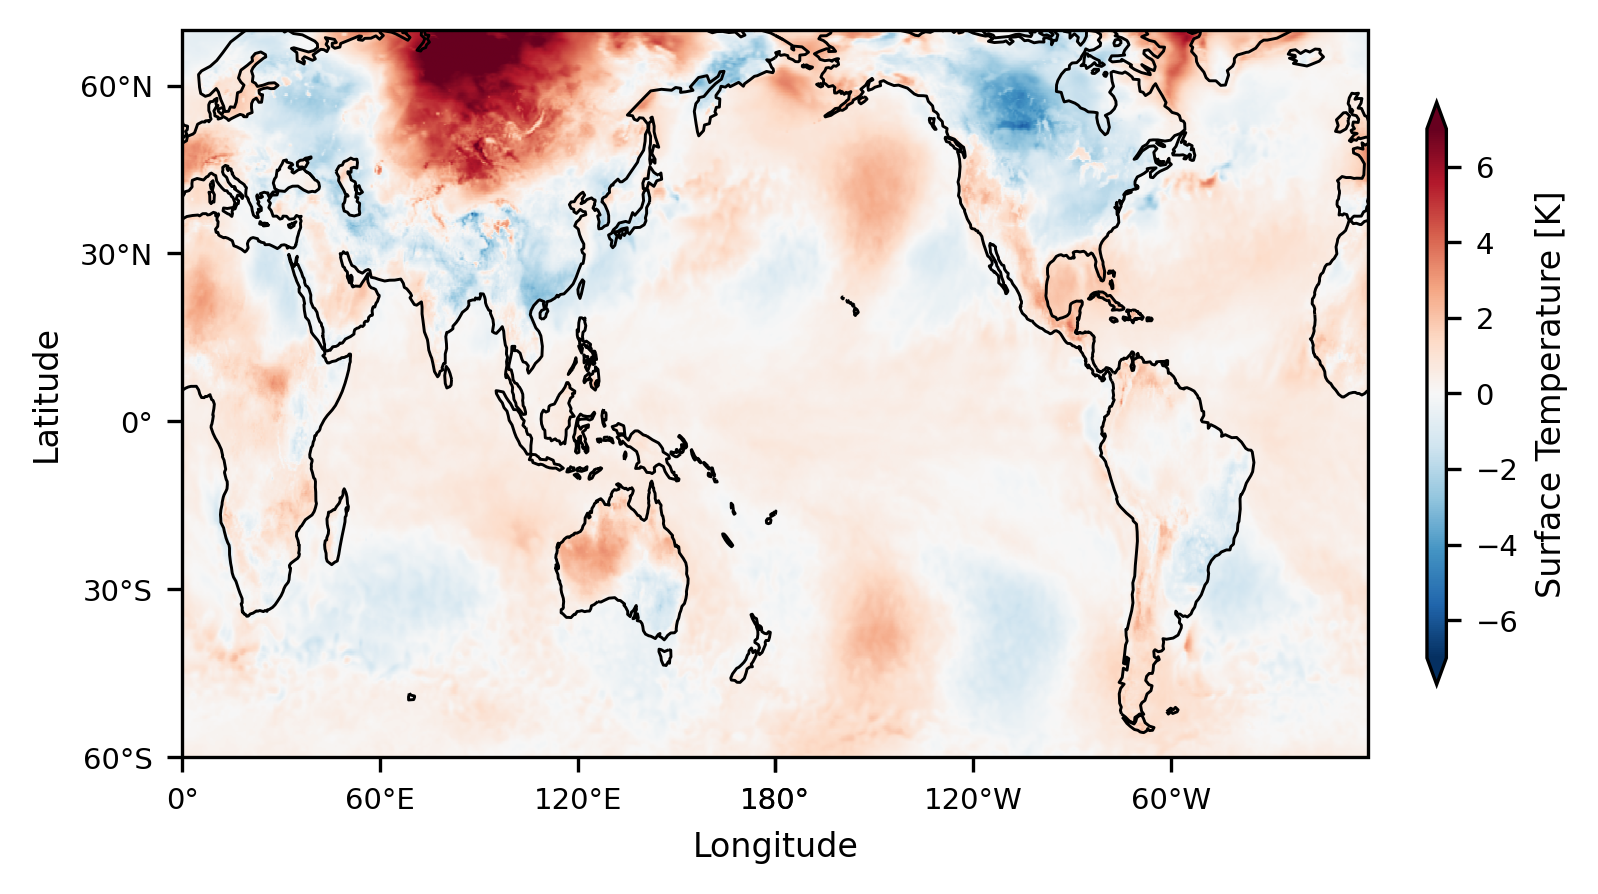

In [35]:
cm = 1/2.54
plt.figure(figsize=(16*cm, 8*cm), dpi=300)

tick_size=7
label_size=8

time = '2020-04'

ax = plt.subplot(projection=ccrs.PlateCarree(180))

# extent = [0, 360, -90, 90]
extent = [0, 360, -60, 70]
ax.set_extent(extent, crs=ccrs.PlateCarree())

lat_loc = np.arange(-60, 61, 30) #np.arange(-90, 91, 30)
lon_loc = np.arange(-180, 181, 60)

ax.set_xticks(lon_loc, crs=ccrs.PlateCarree())
ax.set_yticks(lat_loc, crs=ccrs.PlateCarree())
ax.xaxis.set_major_formatter(LongitudeFormatter())
ax.yaxis.set_major_formatter(LatitudeFormatter())

# tick size
ax.tick_params(labelsize=tick_size)

ax.set_xlabel('Longitude', fontsize=label_size)
ax.set_ylabel('Latitude', fontsize=label_size)

im = ax.imshow(t2m_ano.sel(valid_time=time, latitude=slice(70, -60)).t2m[0], extent=extent, transform=ccrs.PlateCarree(), cmap='RdBu_r', aspect='auto', vmin=-7, vmax=7)
ax.coastlines(color='black', linewidth=0.7)

cb = plt.colorbar(im, pad=0.04, aspect=30, shrink=0.8, extend='both')
cb.ax.tick_params(labelsize=tick_size)
cb.set_label('Surface Temperature [K]', fontsize=label_size)

os.makedirs(f'{out_dir}/era5_t2m_ano', exist_ok=True)
plt.savefig(f'{out_dir}/era5_t2m_ano/{time}.png', bbox_inches='tight')